In [1]:
from cassie import CassieEnv
import numpy as np

import time

env = CassieEnv("walking")

qpos = np.copy(env.sim.qpos())

jpos = qpos[env.pos_idx]

fbpos = qpos[0:7]

# keep feet from intersecting ground
fbpos[2] += 0.2

<IPython.core.display.Javascript object>


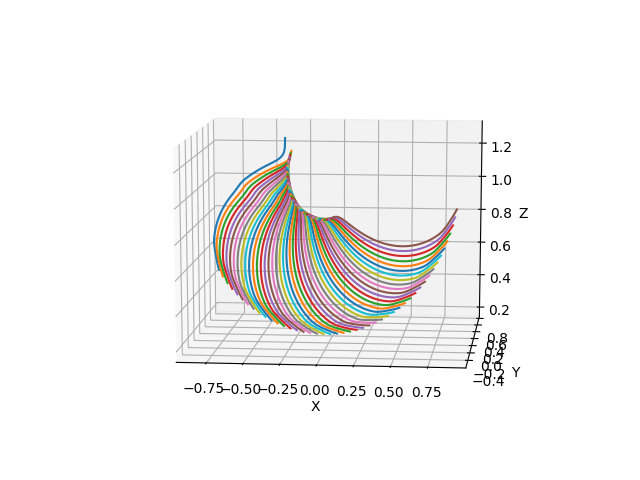

In [2]:
# Joint limits converted to radians from XML file

ROLL_LOW   = -0.26
ROLL_HIGH  =  0.39

YAW_LOW    = -0.39
YAW_HIGH   =  0.39

PITCH_LOW  = -0.87
PITCH_HIGH =  1.4

KNEE_LOW   = -2.86
KNEE_HIGH  = -0.64

FOOT_LOW   = -2.44
FOOT_HIGH  = -0.52

# achilles = .75 + pitch = 1
# not currently correct though
ACHILLES_LIMIT = 1.75

DELTA = 0.05#0.025 # resolution for IK data set
ITERS = 100#500

# ramp down joint angles
while jpos[2] > PITCH_LOW and jpos[3] > KNEE_LOW:
#     qpos = np.copy(env.sim.qpos())
#     if qpos[10] < ACHILLES_ROD_LOW:
#         print(qpos[2])
    
    jpos[2] -= DELTA
    jpos[7] -= DELTA
    
    jpos[3] -= DELTA
    jpos[8] -= DELTA
    
    env.set_joint_pos(jpos, fbpos, iters=ITERS)
    env.render()

%matplotlib notebook

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

ax.axis("equal")

data = []
X = []
Y = []
Z = []

pitch = PITCH_LOW
while pitch < PITCH_HIGH:
    pitch += DELTA
    
    knee = KNEE_LOW
    while knee < KNEE_HIGH:
            knee += DELTA
            
            jpos[2] = pitch
            jpos[7] = pitch

            jpos[3] = knee
            jpos[8] = knee

            env.set_joint_pos(jpos, fbpos, iters=ITERS)
            
            footpos = np.zeros(6)
            env.sim.foot_pos(footpos)
            
            qpos = np.copy(env.sim.qpos())
            qpos = qpos[7:21]
            
            # get XZ foot position relative to center of mass
            footpos_relative = [footpos[0] - fbpos[0], footpos[2] - fbpos[2]]#,
                                #footpos[3] - fbpos[0], footpos[5] - fbpos[2]]
            
            data += [(footpos_relative, qpos)]
                        
            X += [footpos[0]]
            Y += [footpos[1]]
            Z += [footpos[2]]
            
            #if qpos[10] + qpos[2] < ACHILLES_LIMIT:
            #    continue 
                
            env.render()

    ax.plot(X, Y, Z)    
    X = []
    Y = []
    Z = []
    
    # ramp knee angle back down
    while jpos[3] > KNEE_LOW:
        jpos[3] -= DELTA
        jpos[8] -= DELTA
        
        env.set_joint_pos(jpos, fbpos, iters=ITERS)
        env.render()
        
plt.show()

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler
import torch.functional as F

class MLP(nn.Module):
    def __init__(self,
                 num_inputs,
                 num_outputs,
                 nonlinearity="tanh"):

        super(MLP, self).__init__()

        hidden_dims = (16, 16)
        
        self.hidden_layers = nn.ModuleList()
        self.hidden_layers += [nn.Linear(num_inputs, hidden_dims[0])]
        for l in range(len(hidden_dims) - 1):
            in_dim = hidden_dims[l]
            out_dim = hidden_dims[l + 1]
            self.hidden_layers += [nn.Linear(in_dim, out_dim)]
        
        self.out = nn.Linear(hidden_dims[-1], num_outputs)
        
        if nonlinearity == "relu":
            self.nonlinearity = torch.relu
        elif nonlinearity == "tanh":
            self.nonlinearity = torch.tanh
        else:
            raise NotImplementedError

    def forward(self, inputs):
        x = inputs
        for l in self.hidden_layers:
            x = self.nonlinearity(l(x))
        pred = self.out(x)
        
        return pred

x = torch.Tensor(np.array([e[0] for e in data]))
y = torch.Tensor(np.array([e[1] for e in data]))

model = MLP(2, 14, "tanh")
print("# of parameters: ", sum(p.numel() for p in model.parameters()))

print("# of data points: ", y.size(0))
    
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(model.parameters(), lr=1e-2)
for t in range(500):
    sampler = BatchSampler(
        SubsetRandomSampler(range(y.size(0))),
        batch_size=128,
        drop_last=True
    )

    for indices in sampler:
        indices = torch.LongTensor(indices)
        
        y_batch = y[indices]
        x_batch = x[indices]

        # Forward pass: Compute predicted y by passing x to the model
        y_pred = model(x_batch)

        # Compute and print loss
        loss = criterion(y_pred, y_batch)
        
        if t % 10 == 0:
            print(t, loss.item())

        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


# of parameters:  558
# of data points:  2070
0 1900.3629150390625
0 1852.7044677734375
0 1610.523193359375
0 1315.611328125
0 1096.250244140625
0 1012.3184204101562
0 749.8084716796875
0 551.173828125
0 457.66009521484375
0 365.2744445800781
0 315.5885009765625
0 265.96746826171875
0 267.82666015625
0 287.99420166015625
0 293.9889831542969
0 311.13909912109375
10 12.025016784667969
10 9.88425064086914
10 14.567541122436523
10 12.04238224029541
10 14.99541187286377
10 12.581534385681152
10 14.431984901428223
10 16.266300201416016
10 10.187658309936523
10 13.303574562072754
10 11.92365550994873
10 11.656753540039062
10 11.084980964660645
10 14.660289764404297
10 9.960078239440918
10 12.126672744750977
20 5.907732009887695
20 5.3534979820251465
20 5.377225875854492
20 6.590748310089111
20 4.95667028427124
20 4.9568562507629395
20 5.3005595207214355
20 5.258895397186279
20 5.208423137664795
20 5.2247467041015625
20 5.455924034118652
20 4.958731174468994
20 4.7234954833984375
20 5.57197427

240 0.7579582333564758
240 0.8608784675598145
240 0.8702462911605835
240 0.6823126673698425
240 0.6298151016235352
240 0.9415977597236633
240 0.5440163016319275
240 0.7332127094268799
240 0.7715004682540894
240 0.6241600513458252
240 0.6860158443450928
240 0.9302883148193359
240 0.9237106442451477
240 1.1314958333969116
240 0.742399275302887
240 0.5484344959259033
250 0.8194181323051453
250 0.8568183183670044
250 0.8721489310264587
250 0.7680947780609131
250 1.014748454093933
250 0.9091472625732422
250 0.7386370897293091
250 0.5295075178146362
250 0.8291460275650024
250 0.9718536138534546
250 0.7487902045249939
250 0.958563506603241
250 0.770658016204834
250 0.7455930709838867
250 0.8276562690734863
250 0.7560749053955078
260 0.9673609733581543
260 0.6622135043144226
260 0.7056403756141663
260 0.5512333512306213
260 0.6594748497009277
260 1.115999460220337
260 0.5250073075294495
260 0.6930239200592041
260 0.6508287787437439
260 0.440547376871109
260 0.6961047649383545
260 1.36569368839

470 0.9216932058334351
470 0.9351440668106079
470 0.692209780216217
470 0.44408172369003296
470 1.0831071138381958
470 0.7380847930908203
470 0.7816756367683411
470 0.8325396776199341
470 0.7206305265426636
470 0.6052119731903076
470 0.41017457842826843
470 0.564295768737793
470 0.37274494767189026
470 0.7445425391197205
470 0.7132239937782288
470 0.6099638342857361
480 0.5231595635414124
480 0.5602094531059265
480 0.31946539878845215
480 0.48246073722839355
480 0.8530197739601135
480 0.7697498202323914
480 0.8139410018920898
480 0.9300426244735718
480 0.8199521899223328
480 0.8267915844917297
480 0.5596922039985657
480 1.054638385772705
480 0.8574840426445007
480 0.5014398097991943
480 0.7891603112220764
480 0.45297157764434814
490 0.8272114396095276
490 0.7470816373825073
490 1.4258038997650146
490 0.6679200530052185
490 0.8011289834976196
490 0.9087895750999451
490 0.686012864112854
490 0.79549640417099
490 0.8490064144134521
490 0.4657076597213745
490 0.6772597432136536
490 1.08348

In [10]:
import pickle
from cassie.cassiemujoco import pd_in_t

with open("bslip_stepping_traj.pkl", "rb") as f:
    bslip_data = pickle.load(f)

traj_qpos = []
for i in range(1500, 2500):
    fpos_des = torch.Tensor(bslip_data["foot"][i])

    lfoot = fpos_des[0:2]
    rfoot = fpos_des[2:4]

    qposl = model(lfoot).detach().numpy()
    qposr = model(rfoot).detach().numpy()

    #print(fpos_des)
    #qpos = qpos.detach().numpy()

    qpos = np.concatenate([fbpos, qposl, qposr])

    qpos[0] = bslip_data["com"][i][0]
    qpos[2] = bslip_data["com"][i][1] + 0.065 # 0.65 accounts for height of foot
    
    traj_qpos += [qpos]

    env.sim.set_qpos(qpos)
    env.sim.step_pd(pd_in_t())
    env.render()

    #time.sleep(1/30)

### 

In [8]:
print(len(traj_qpos))

# Now we gotta estimate the qvels using finite difference estimates of d qpos / dt

traj_qvel = []
for i in range(len(traj_qpos)):
    # note: index < 0 is valid because this is a periodic trajectory
    traj_qvel += [(traj_qpos[i] - traj_qpos[i - 1]) / (1/2000)]

trajectory = {"qpos": traj_qpos, "qvel": traj_qvel}

with open("cassie/trajectory/stepping_traj.pkl", "wb") as f:
    pickle.dump(trajectory, f)

1000
